# Instructions:
* download mvgenTL from here: https://assets-2.balluff.com/mvIMPACT_Acquire/2.46.0/mvGenTL_Acquire-x86_64-2.46.0.exe
* find the location of the CTI path in the installed folder from above and set in the CTI_PATH variable in the first cell. in the telescope room's computer the path is: C:\Program Files\MATRIX VISION\mvIMPACT Acquire\bin\x64\mvGenTLProducer.cti, so it should be something like so
* use either a python interpreter of version <= 3.11 or anaconda python.
* pip/conda install genicam
* pip/conda install harvesters
* make sure the Teledyne camera is connected to the computer and has a blue light on on it's back.


In [11]:
from harvesters.core import Harvester
from matplotlib import pyplot as plt
import numpy as np
from time import sleep
from IPython.display import display, clear_output
from scipy.optimize import curve_fit
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import FloatSlider, Layout


CTI_PATH = r"C:\Program Files\MATRIX VISION\mvIMPACT Acquire\bin\x64\mvGenTLProducer.cti"

TELEDYNE_PIXELS_SIZE = 4.8e-6  # 4.8 µm (pixel size in meters)

# Define Gaussian function for 2D fitting
def gaussian_2d(xdata_tuple, x0, y0, sigma_x, sigma_y, amplitude, offset):
    (x, y) = xdata_tuple
    # 2D Gaussian formula with center (x0, y0), std deviations (sigma_x, sigma_y), amplitude, and offset
    return (amplitude * np.exp(
        -(((x - x0) ** 2 / (2 * abs(sigma_x) ** 2)) + ((y - y0) ** 2 / (2 * abs(sigma_y) ** 2))))
            + offset).ravel()


# Reduce image resolution by subsampling (no convolution)
def reduce_resolution(image, factor=4):
    return image[::factor, ::factor]  # Subsampling by taking every nth pixel


# Calculate weighted mean (center) and standard deviation (width) of the beam
def calc_weighted_mean_and_std(image):
    height, width = image.shape
    x = np.arange(width)
    y = np.arange(height)

    # Find the brightest pixel (approximate center)
    max_index = np.argmax(image)
    total_intensity = np.sum(image)
    center_y, center_x = np.unravel_index(max_index, image.shape)  # Note: (y, x) order

    # Calculate weighted standard deviations (beam width) for x and y axes
    std_x = np.sqrt(np.sum(((x - center_x) ** 2) * np.sum(image, axis=0)) / total_intensity)
    std_y = np.sqrt(np.sum(((y - center_y) ** 2) * np.sum(image, axis=1)) / total_intensity)

    return center_x, center_y, std_x, std_y


# Fit the 2D Gaussian to the reduced resolution image
def fit_gaussian(image, center_x, center_y, std_x, std_y, **kwargs):
    height, width = image.shape
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)

    # Initial guess for the Gaussian fit
    initial_guess = (center_x, center_y, abs(std_x), abs(std_y), np.max(image), np.min(image))

    # Flatten the coordinates for curve fitting
    xdata = np.vstack((x.ravel(), y.ravel()))

    # Try to fit the Gaussian, return NaN if it fails
    try:
        popt, _ = curve_fit(gaussian_2d, xdata, image.ravel(), p0=initial_guess, 
                            bounds=([-np.inf, -np.inf, 0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), **kwargs)
        return popt
    except Exception as e:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan  # If fit fails, return NaNs


# Main function to process the image
def process_image(image, resolution_reduction_factor=4, pixel_width_m=None, pixel_height_m=None):
    # Set default pixel dimensions if not provided
    if pixel_width_m is None:
        pixel_width_m = 1
    if pixel_height_m is None:
        pixel_height_m = pixel_width_m

    # Step 1: Reduce resolution of the image
    reduced_image = reduce_resolution(image, factor=resolution_reduction_factor)

    # Step 2: Calculate initial beam center and standard deviations (widths)
    center_x, center_y, std_x, std_y = calc_weighted_mean_and_std(reduced_image)
    std_x, std_y = 10, 10
    # Step 3: Perform Gaussian fit on the reduced image
    popt = fit_gaussian(reduced_image, center_x, center_y, std_x, std_y, maxfev=200)
    

    # Extract fitted parameters and scale back to original coordinates
    fitted_center_x, fitted_center_y, fitted_std_x, fitted_std_y, amplitude, offset = popt
    fitted_center_x *= resolution_reduction_factor
    fitted_center_y *= resolution_reduction_factor
    fitted_std_x *= resolution_reduction_factor
    fitted_std_y *= resolution_reduction_factor

    # Convert to meters (scale by pixel size)
    center_x_m = center_x * resolution_reduction_factor * pixel_width_m
    center_y_m = center_y * resolution_reduction_factor * pixel_height_m
    std_x_m = std_x * resolution_reduction_factor * pixel_width_m
    std_y_m = std_y * resolution_reduction_factor * pixel_height_m

    fitted_center_x_m = fitted_center_x * pixel_width_m
    fitted_center_y_m = fitted_center_y * pixel_height_m
    fitted_std_x_m = fitted_std_x * pixel_width_m
    fitted_std_y_m = fitted_std_y * pixel_height_m

    # Return the result as a dictionary with all parameters and scaling factors
    return {
        'initial_center': (center_x * resolution_reduction_factor, center_y * resolution_reduction_factor),
        'initial_std': (std_x * resolution_reduction_factor, std_y * resolution_reduction_factor),
        'fitted_center': (fitted_center_x, fitted_center_y),
        'fitted_std': (fitted_std_x, fitted_std_y),
        'initial_center_m': (center_x_m, center_y_m),
        'initial_std_m': (std_x_m, std_y_m),
        'fitted_center_m': (fitted_center_x_m, fitted_center_y_m),
        'fitted_std_m': (fitted_std_x_m, fitted_std_y_m),
        'amplitude': amplitude,
        'offset': offset,
        'factor_x': pixel_width_m,
        'factor_y': pixel_height_m
    }


# Updated function to update plots and return the image handle and line objects
def plot_gaussian_fitting(fig, ax_image, im, image, result_dict, ax_history, line_x, line_y, sigma_x_history, sigma_y_history, vmax=None):
    # Extract Gaussian fit results
    fitted_center_x_m = result_dict['fitted_center_m'][0]
    fitted_center_y_m = result_dict['fitted_center_m'][1]
    fitted_std_x_m = result_dict['fitted_std_m'][0]
    fitted_std_y_m = result_dict['fitted_std_m'][1]

    # Scale the image axes to meters
    height, width = image.shape
    factor_x = result_dict['factor_x']
    factor_y = result_dict['factor_y']
    extent = [0, width * factor_x, height * factor_y, 0]
    if vmax is None:
        vmax=np.max(image)
    
    # Update image plot (create it if it doesn't exist)
    if im is None:
        im = ax_image.imshow(image, cmap='gray', extent=extent, vmax=vmax)
        fig.colorbar(im, ax=ax_image)
    else:
        im.set_data(image)

    # Clear existing ellipses and add new ones for the fitted Gaussian
    for artist in list(ax_image.patches):
        artist.remove()
    
    # Clear lines
    for artist in list(ax_image.lines):
        artist.remove()

    # Only plot ellipses if the fit succeeded
    if not np.isnan(fitted_center_x_m) and fitted_std_x_m < 3e-2:
        colors = ['r', 'g']
        for i in range(1, 3):  # Draw 1σ and 2σ ellipses
            ellipse = patches.Ellipse(
                (fitted_center_x_m, fitted_center_y_m),
                width=2 * i * fitted_std_x_m,
                height=2 * i * fitted_std_y_m,
                edgecolor=colors[i - 1],
                fill=False,
                linestyle='--',
                linewidth=1.5,
                label=f'{i}σ'
            )
            ax_image.add_patch(ellipse)
            ax_image.axvline(fitted_center_x_m)
            ax_image.axhline(fitted_center_y_m)

        # Update plot title and text display for σ_x and σ_y
        ax_image.set_title(f"Gaussian Fit\nσ_x: {fitted_std_x_m:.2e} m, σ_y: {fitted_std_y_m:.2e} m\n mu_x = {fitted_center_x_m:.2e}, mu_y = {fitted_center_y_m:.2e}", fontsize=20)
        ax_image.set_xlabel('X (m)')
        ax_image.set_ylabel('Y (m)')
        [txt.remove() for txt in ax_image.texts]  # Remove previous large text
#         ax_image.text(0.5, 1.1, f"σ_x: {fitted_std_x_m:.1e} m, σ_y: {fitted_std_y_m:.1e} m\nmu_x: {fitted_center_x_m:.1e} m, mu_y = {fitted_center_y_m:.1e} m",
#                       fontsize=70, ha='center', transform=ax_image.transAxes)

        # Add current σ values to history
        sigma_x_history.append(fitted_std_x_m)
        sigma_y_history.append(fitted_std_y_m)
    else:
        ax_image.set_title(f"Gaussian Fit Failed")
        ax_image.set_xlabel('X (m)')
        ax_image.set_ylabel('Y (m)')
        sigma_x_history.append(np.nan)
        sigma_y_history.append(np.nan)
    
    last_index_for_plotting = len(sigma_x_history)
    first_index_for_plotting = max(0, last_index_for_plotting-100)
    x_axis_for_plotting = np.arange(first_index_for_plotting, last_index_for_plotting)
    # Update line plots for σ_x and σ_y history
    line_x.set_data(x_axis_for_plotting, sigma_x_history[first_index_for_plotting:last_index_for_plotting])
    line_y.set_data(x_axis_for_plotting, sigma_y_history[first_index_for_plotting:last_index_for_plotting])

    # Adjust the axis limits to fit current data
    ax_history.relim()
    ax_history.set_ylim(0, np.nan_to_num(max(sigma_x_history[-1], sigma_y_history[-1]) * 2, np.nanmax(sigma_y_history)))
    ax_history.set_ylim(0, np.nan_to_num(np.nanmax(np.stack((sigma_x_history[first_index_for_plotting:last_index_for_plotting],
                                                             sigma_y_history[first_index_for_plotting:last_index_for_plotting]))), 1) * 1.1)
    total_intensity = np.sum(image)
    ax_history.set_title(f"Total Intensity: {total_intensity:.2e}")

    ax_history.autoscale_view()

    return im, line_x, line_y  # Return updated image and lines


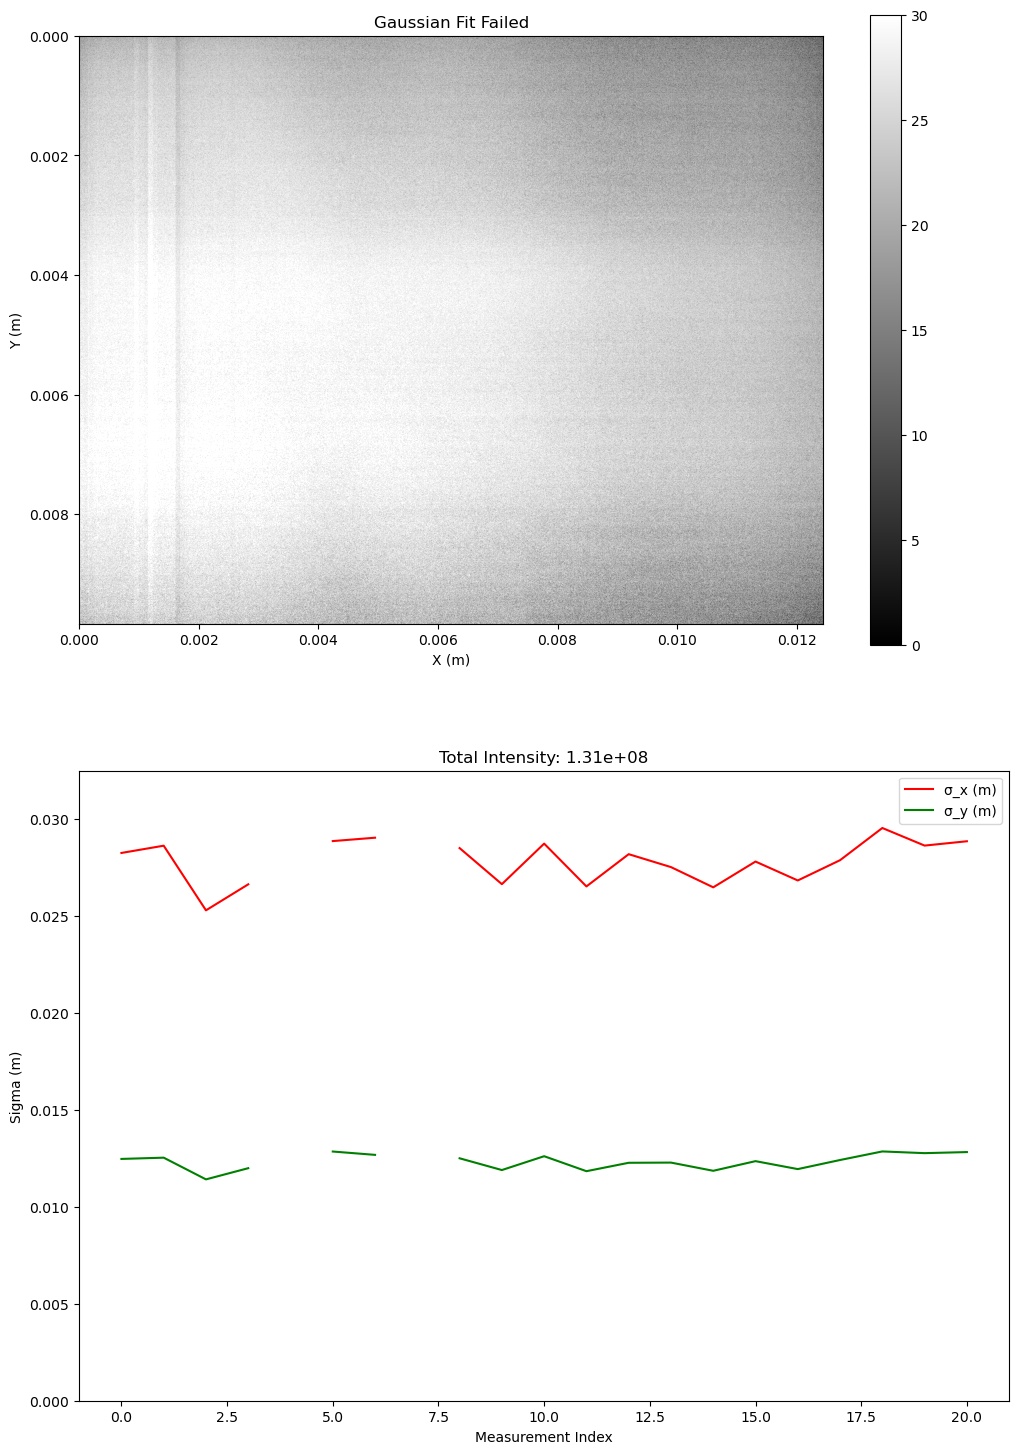

In [12]:
fig, (ax_image, ax_history) = plt.subplots(2, 1, figsize=(12, 18))
exposure_time_ms = 400
gain = 2
camera_id = 0
vmax = 30

with Harvester() as h:
    # Add camera file and update Harvester settings
    h.add_file(CTI_PATH)
    print(h.device_info_list)
    h.update()
    print(gain)

    # Create a figure and two subplots: one for the image, one for sigma_x/y history
    im = None

    # Initialize line plots for sigma_x and sigma_y
    line_x, = ax_history.plot([], [], 'r-', label='σ_x (m)')  # Red line for sigma_x
    line_y, = ax_history.plot([], [], 'g-', label='σ_y (m)')  # Green line for sigma_y
    ax_history.set_xlabel('Measurement Index')  # X-axis label for measurement index
    ax_history.set_ylabel('Sigma (m)')  # Y-axis label for sigma values in meters
    ax_history.legend()  # Display the legend for the plots

    # Lists to store sigma values over time
    sigma_x_history = []
    sigma_y_history = []

    with h.create(camera_id) as ia:  # Create an image acquisition object
        ia.start()  # Start image acquisition
        node_map = ia.remote_device.node_map  # Get the node map for camera settings
        node_map.ExposureTime.set_value(exposure_time_ms)  # Set exposure time
        node_map.Gain.set_value(gain)  # Set camera gain

        while True:
            try:
                # Fetch image buffer from the camera
                with ia.fetch() as buffer:
                    # Extract image data from buffer
                    _1d = buffer.payload.components[0].data
                    height, width = buffer.payload.components[0].height, buffer.payload.components[0].width
                    image = _1d.reshape(height, width)  # Reshape 1D data to 2D image

                sleep(0.25)  # Pause for 1 second

                # Process the image and perform Gaussian fitting
                result_dict = process_image(
                    image, 
                    resolution_reduction_factor=8,  # Set resolution reduction factor
                    pixel_width_m=TELEDYNE_PIXELS_SIZE, 
                    pixel_height_m=TELEDYNE_PIXELS_SIZE
                )

                # Update both image and line plots
                im, line_x, line_y = plot_gaussian_fitting(
                    fig, ax_image, im, image, result_dict, ax_history, line_x, line_y, 
                    sigma_x_history, sigma_y_history, vmax=vmax
                )
                # Redraw the plots
                clear_output(wait=True)  # Clear the previous frame
                display(fig)  # Display the updated figure
                plt.pause(0.01)  # Pause to allow the plot to refresh

            except (KeyboardInterrupt, IndexError) as e:
#                 print(e)  # Print the error message
                ia.stop()  # Stop image acquisition on error or interruption
                break  # Exit the loop
    ia.stop()  # Ensure the acquisition stops after the loop exits


In [8]:
%debug

> c:\users\osiplab\appdata\local\temp\ipykernel_12568\1781699082.py(142)plot_gaussian_fitting()

ipdb> type(image)
<class 'numpy.ndarray'>
ipdb> type(ax_image)
<class 'matplotlib.axes._axes.Axes'>
ipdb> q


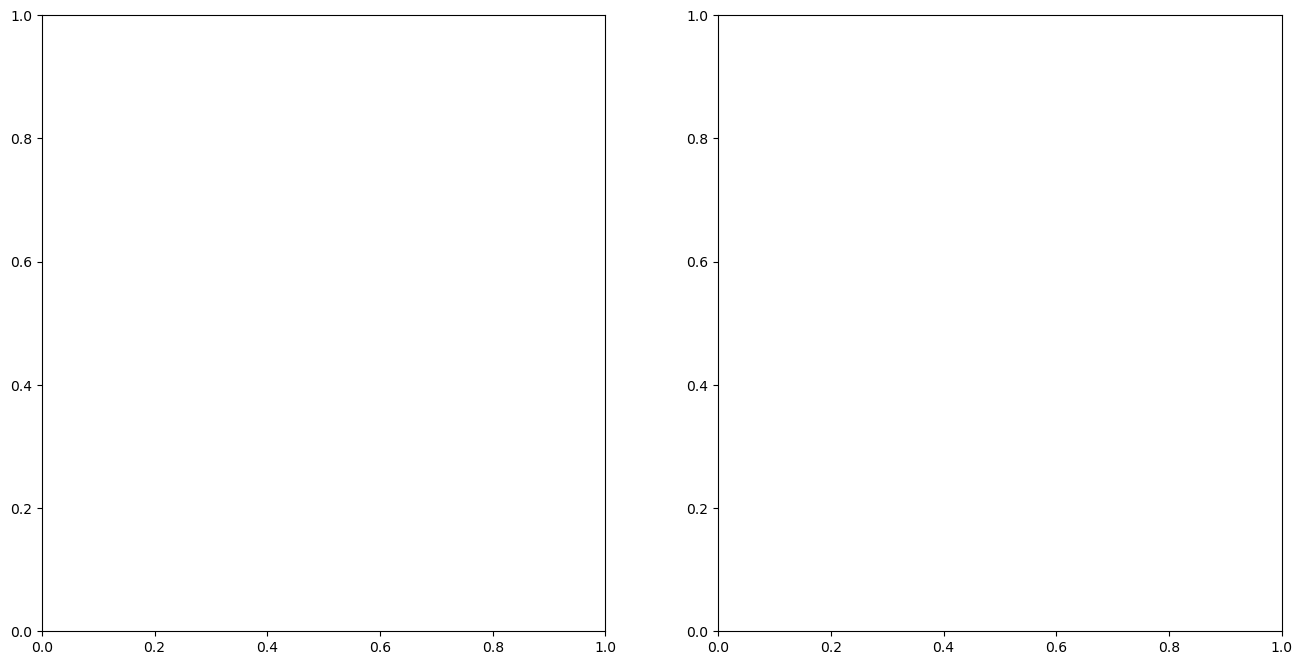

'NoneType' object has no attribute 'deregister_node_callbacks'


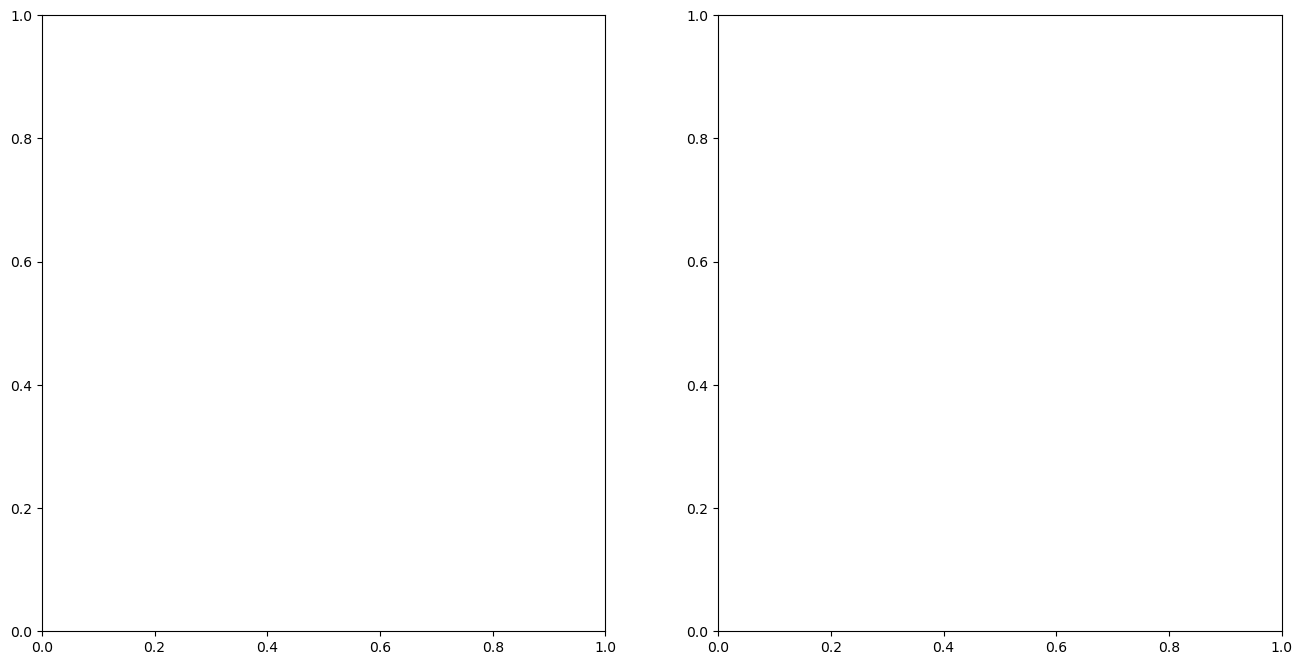

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
display(fig)
with Harvester() as h:
    # Add camera file and update Harvester settings
    h.add_file(CTI_PATH)
    h.update()
    
    while True:
        try:
            with h.create(0) as ia:
                ia.start()
                with ia.fetch() as buffer_a:
                    _1d = buffer_a.payload.components[0].data
                    height, width = buffer_a.payload.components[0].height, buffer_a.payload.components[0].width
                    image_a = _1d.reshape(height, width)  # Reshape 1D data to 2D image
                    image_a = np.flip(image_a, axis=0)
                sleep(0.4)

            with h.create(1) as ib:
                ib.start()
                with ib.fetch() as buffer_b:
                    _1d_b = buffer_b.payload.components[0].data
                    height, width = buffer_b.payload.components[0].height, buffer_b.payload.components[0].width
                    image_b = _1d_b.reshape(height, width)  # Reshape 1D data to 2D image
                    image_b = np.flip(image_b, axis=0)
                sleep(0.4)

            ax[0].imshow(image_a)
            ax[1].imshow(image_b)
            
            # Redraw the plots
            clear_output(wait=True)  # Clear the previous frame
            display(fig)  # Display the updated figure
            plt.pause(0.01)  # Pause to allow the plot to refresh
            
        except Exception as e:  # (KeyboardInterrupt, IndexError)
            print(e)  # Print the error message
            ia.stop()  # Stop image acquisition on error or interruption
            break  # Exit the loop
        ia.stop()  # Ensure the acquisition stops after the loop exits


In [31]:
from harvesters.core import Harvester
from matplotlib import pyplot as plt
import numpy as np
from time import sleep
from IPython.display import display, clear_output
exposure_time_ms = 5

fig, ax = plt.subplots()
with Harvester() as h:
    # Add camera file and update Harvester settings
    h.add_file(CTI_PATH)
    h.update()
    with h.create(1) as ia:
        ia.start()
        while True:
            try:
                with ia.fetch() as buffer_a:
                    node_map = ia.remote_device.node_map  # Get the node map for camera settings
                    node_map.ExposureTime.set_value(exposure_time_ms)  # Set exposure time
                    _1d = buffer_a.payload.components[0].data
                    height, width = buffer_a.payload.components[0].height, buffer_a.payload.components[0].width
                    image_a = _1d.reshape(height, width)  # Reshape 1D data to 2D image
                sleep(0.25)

                ax.imshow(image_a)
                # Redraw the plots
                clear_output(wait=True)  # Clear the previous frame
                display(fig)  # Display the updated figure
                plt.pause(0.01)  # Pause to allow the plot to refresh
            
            except Exception as e:  # (KeyboardInterrupt, IndexError)
                print(e)  # Print the error message
                ia.stop()  # Stop image acquisition on error or interruption
                break  # Exit the loop
        ia.stop()  # Ensure the acquisition stops after the loop exits


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000022CF7E00D30> (for post_execute):



KeyboardInterrupt

